# Super-Resolution

This example demonstrates the use of neural operators for
super-resolution.

We will employ the FLAME dataset - a set of flow samples of size 32x32 that
should be up-sampled to 128x128.

> Download the data set manually from
[Kaggle](https://www.kaggle.com/competitions/2023-flame-ai-challenge/data)
and put it into the `data/flame` directory.

## Setup

Import modules.

In [1]:
import torch
import matplotlib.pyplot as plt
from continuity.data.flame import FlameDataLoader, FlameDataSet
from continuity.plotting import plot

In [2]:
torch.manual_seed(1)
plt.rcParams["axes.facecolor"] = (1, 1, 1, 0)
plt.rcParams["figure.facecolor"] = (1, 1, 1, 0)
plt.rcParams["legend.framealpha"] = 0.0


## Dataset

Create `FlameDataSet` that exports batches of samples
from the flame data.

Dataset contains 4 batches.


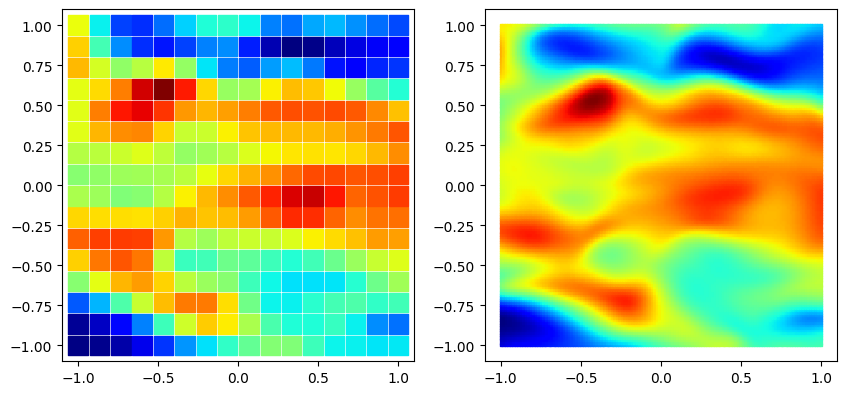

In [3]:
size = 4
loader = FlameDataLoader(path='../data/flame')
dataset = FlameDataSet(loader, size=128, split="train", channels=["ux"])
print(f"Dataset contains {len(dataset)} batches.")

# Plot first sample
first_batch = dataset[0]
x, u, y, v = [a[0] for a in first_batch]
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot(x, u, ax=ax[0])
plot(y, v, ax=ax[1])